<a href="https://colab.research.google.com/github/ShravyaMalogi/PROJECT_drafts/blob/main/ad1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

bad_files = []

with zipfile.ZipFile('/content/drive/MyDrive/projects/datasets/imdbwiki.zip', 'r') as zipf:
    for file in zipf.filelist:
        try:
            zipf.open(file.filename).read()
        except:
            bad_files.append(file.filename)

print("🛑 Corrupted files found:")
for bf in bad_files:
    print(bf)

🛑 Corrupted files found:
imdb-clean-1024/imdb-clean-1024/22/nm0266422_rm3838610432_1974-9-19_2005.jpg
imdb-clean-1024/imdb-clean-1024/24/nm1861624_rm3706501120_1982-11-15_2010.jpg
imdb-clean-1024/imdb-clean-1024/25/nm1553725_rm2946674688_1985-3-15_2011.jpg
imdb-clean-1024/imdb-clean-1024/41/nm0266441_rm2134412800_1961-5-13_1994.jpg
imdb-clean-1024/imdb-clean-1024/43/nm0001743_rm2994522112_1948-1-29_1984.jpg
imdb-clean-1024/imdb-clean-1024/73/nm0001173_rm2329378816_1968-3-12_2008.jpg


In [4]:
import zipfile
import os

# Path to the zip file on your Google Drive
zip_path = '/content/drive/MyDrive/projects/datasets/imdbwiki.zip'  # change this
extract_path = '/content/imdb-wiki_data'

# List of corrupted files inside the ZIP to skip
corrupted_files = [
    'imdb-clean-1024/imdb-clean-1024/22/nm0266422_rm3838610432_1974-9-19_2005.jpg',
    'imdb-clean-1024/imdb-clean-1024/24/nm1861624_rm3706501120_1982-11-15_2010.jpg',
    'imdb-clean-1024/imdb-clean-1024/25/nm1553725_rm2946674688_1985-3-15_2011.jpg',
    'imdb-clean-1024/imdb-clean-1024/41/nm0266441_rm2134412800_1961-5-13_1994.jpg',
    'imdb-clean-1024/imdb-clean-1024/43/nm0001743_rm2994522112_1948-1-29_1984.jpg',
    'imdb-clean-1024/imdb-clean-1024/73/nm0001173_rm2329378816_1968-3-12_2008.jpg'
]

# Extract all except corrupted files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file not in corrupted_files:
            try:
                zip_ref.extract(file, extract_path)
            except Exception as e:
                print(f"Error extracting {file}: {e}")
        else:
            print(f"Skipping corrupted file: {file}")


Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/22/nm0266422_rm3838610432_1974-9-19_2005.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/24/nm1861624_rm3706501120_1982-11-15_2010.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/25/nm1553725_rm2946674688_1985-3-15_2011.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/41/nm0266441_rm2134412800_1961-5-13_1994.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/43/nm0001743_rm2994522112_1948-1-29_1984.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/73/nm0001173_rm2329378816_1968-3-12_2008.jpg


# Code

In [5]:
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [6]:
csv_path = '/content/imdb-wiki_data/imdb_train_new_1024.csv'
df = pd.read_csv(csv_path)
df.head()

,filename,age,gender,x_min,y_min,x_max,y_max,head_roll,head_yaw,head_pitch
0,05/nm0200005_rm3512895744_1959-12-24_2009.jpg,50,M,78.0,93.0,155.0,185.0,20.134891,-34.811884,-5.720485
1,02/nm0001002_rm1464638208_1966-7-31_2006.jpg,40,M,123.0,175.0,245.0,349.0,11.789708,23.570937,-18.610900
2,00/nm0000100_rm103389184_1955-1-6_2005.jpg,50,M,52.0,70.0,103.0,139.0,0.209951,-20.153913,-13.759556
3,04/nm0024404_rm2909178368_1978-2-20_2009.jpg,31,F,28.0,38.0,55.0,75.0,9.971704,-10.203414,-1.376687
4,00/nm0703800_rm31823616_1959-6-6_2008.jpg,49,M,69.0,100.0,137.0,199.0,5.041017,14.441552,12.871575


In [7]:
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
import os

class AgeDataGenerator(Sequence):
    def __init__(self, dataframe, image_dir, batch_size=32, img_size=(128, 128), shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        X, y = [], []
        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.image_dir, row['filename'])
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.resize(img, self.img_size)
                img = img.astype(np.float32) / 255.0
                X.append(img)
                y.append(row['age'])
            except:
                continue

        return np.array(X), np.array(y)

In [8]:
import pandas as pd

train_df = pd.read_csv('/content/imdb-wiki_data/imdb_train_new_1024.csv')
val_df = pd.read_csv('/content/imdb-wiki_data/imdb_valid_new_1024.csv')
test_df = pd.read_csv('/content/imdb-wiki_data/imdb_test_new_1024.csv')

In [9]:
image_dir = '/content/imdb-wiki_data/imdb-clean-1024/imdb-clean-1024/'

train_gen = AgeDataGenerator(train_df, image_dir=image_dir, batch_size=32)
val_gen = AgeDataGenerator(val_df, image_dir=image_dir, batch_size=32, shuffle=False)
test_gen = AgeDataGenerator(test_df, image_dir=image_dir, batch_size=32, shuffle=False)

# Sample testing

In [10]:
# Fetch one batch of data from the train generator
X_batch, y_batch = train_gen[0]

print(f"Shape of X_batch: {X_batch.shape}")  # Expect (batch_size, 128, 128, 3)
print(f"Shape of y_batch: {y_batch.shape}")  # Expect (batch_size,)
print(f"First 5 ages: {y_batch[:5]}")

Shape of X_batch: (32, 128, 128, 3)
Shape of y_batch: (32,)
First 5 ages: [55 34 25 37 39]


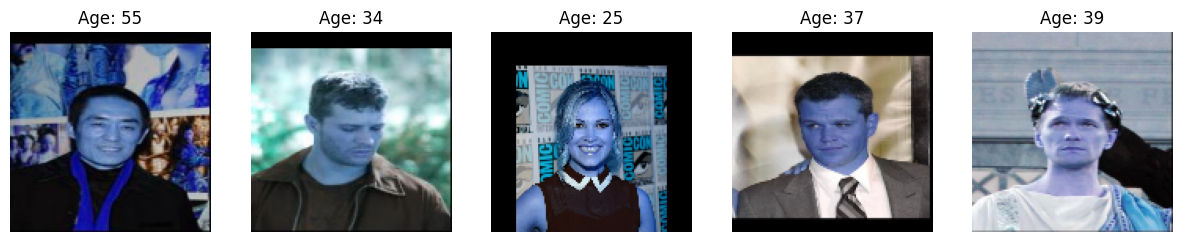

In [11]:
import matplotlib.pyplot as plt

def show_generator_samples(X, y, num=5):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(X[i])
        plt.title(f'Age: {int(y[i])}')
        plt.axis('off')
    plt.show()

show_generator_samples(X_batch, y_batch)


# Code 2

In [12]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_absolute_error, r2_score

In [13]:
def build_model(input_shape=(128, 128, 3)):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Regression output
    ])
    return model

In [14]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',  # Because it's a regression task
    metrics=['mae']  # Mean Absolute Error is great for age prediction
)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    epochs=100,  # Allow more epochs
    validation_data=val_gen,
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5747/5747 ━━━━━━━━━━━━━━━━━━━━ 608s 104ms/step - loss: 210.2832 - mae: 11.2158 - val_loss: 105.2744 - val_mae: 7.9473
Epoch 2/100
5747/5747 ━━━━━━━━━━━━━━━━━━━━ 534s 93ms/step - loss: 131.7860 - mae: 8.9538 - val_loss: 92.4017 - val_mae: 7.4370
Epoch 3/100
5747/5747 ━━━━━━━━━━━━━━━━━━━━ 535s 93ms/step - loss: 117.2154 - mae: 8.4192 - val_loss: 112.8147 - val_mae: 8.1944
Epoch 4/100
5747/5747 ━━━━━━━━━━━━━━━━━━━━ 532s 93ms/step - loss: 105.1200 - mae: 7.9917 - val_loss: 119.5995 - val_mae: 8.7717
Epoch 5/100
5747/5747 ━━━━━━━━━━━━━━━━━━━━ 532s 93ms/step - loss: 96.0450 - mae: 7.6023 - val_loss: 109.4249 - val_mae: 8.3779
Epoch 6/100
5747/5747 ━━━━━━━━━━━━━━━━━━━━ 546s 95ms/step - loss: 89.0137 - mae: 7.3161 - val_loss: 88.5568 - val_mae: 7.3578
Epoch 7/100
5747/5747 ━━━━━━━━━━━━━━━━━━━━ 547s 95ms/step - loss: 82.2057 - mae: 7.0446 - val_loss: 115.5018 - val_mae: 8.5899
Epoch 8/100
5747/5747 ━━━━━━━━━━━━━━━━━━━━ 550s 96ms/step - loss: 78.1356 - mae: 6.8702 - val_loss: 79.9302 - val_mae: 

In [19]:
model.save("age_detection_model.keras")

In [20]:
from google.colab import files
files.download("age_detection_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing

In [35]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Load your test CSV
test_df = pd.read_csv("/content/imdb-wiki_data/imdb_test_new_1024.csv")

# 2. Set the base image directory (where the 00-99 folders are stored)
test_img_dir = "/content/imdb-wiki_data/imdb-clean-1024/imdb-clean-1024/"  # Update if different

# 3. Create ImageDataGenerator for testing (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Create test generator
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_img_dir,
    x_col='filename',
    y_col='age',  # required for evaluation
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw',  # for regression
    shuffle=False
)


Found 56084 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [36]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(test_gen)
print("Test Loss (MAE):", test_loss, test_mae)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1753/1753 ━━━━━━━━━━━━━━━━━━━━ 116s 66ms/step - loss: 122.5519 - mae: 8.4820
Test Loss (MAE): 117.02662658691406 8.322798728942871


1753/1753 ━━━━━━━━━━━━━━━━━━━━ 110s 62ms/step


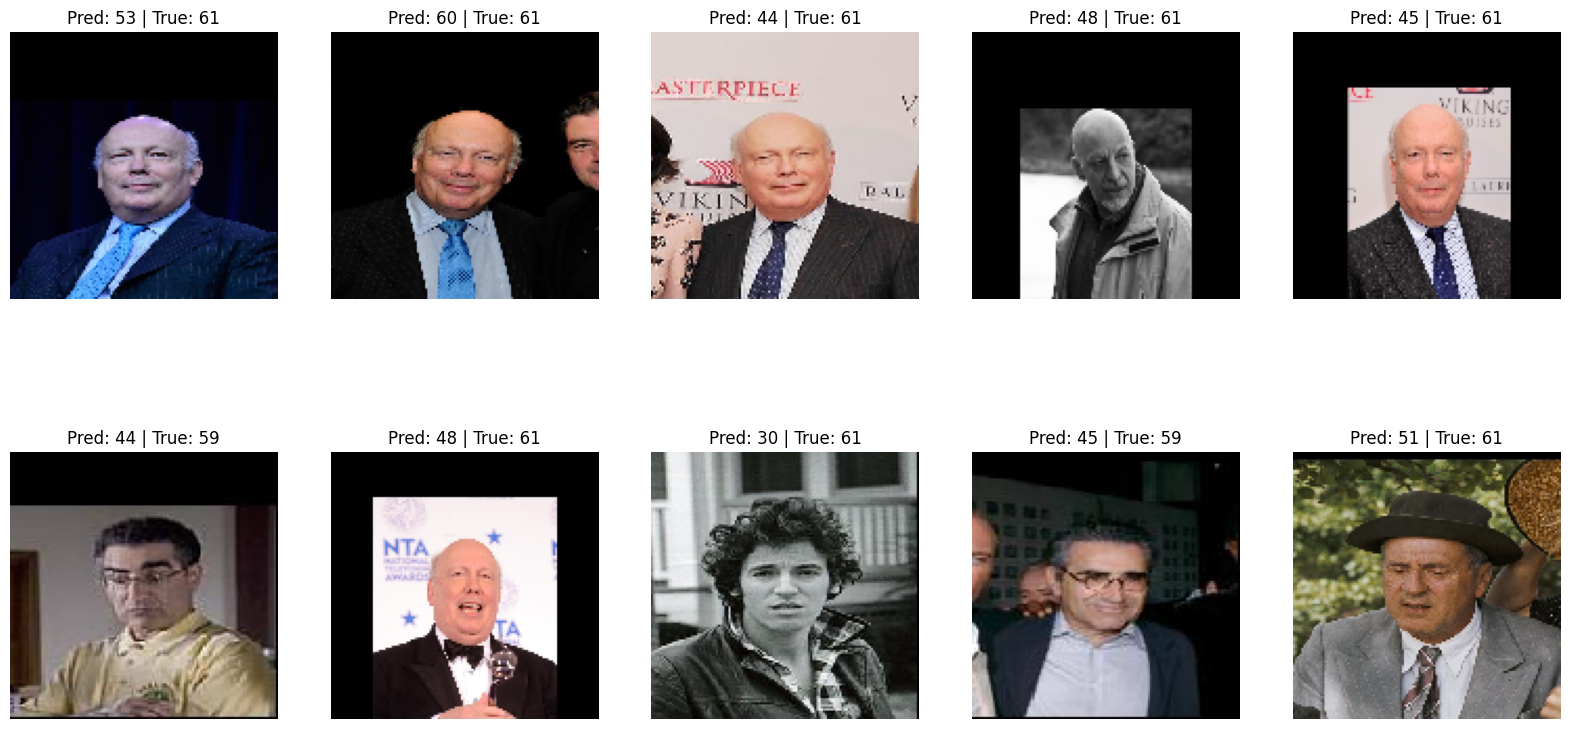

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Predict ages using the model
preds = model.predict(test_gen, verbose=1)
preds = preds.flatten()

# 2. Show first 10 images from test set with predicted and actual age
num_images = 10
images, labels = next(test_gen)  # one batch
plt.figure(figsize=(20, 10))

for i in range(num_images):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

    # Optional: show actual age if available
    actual_age = labels[i] if labels is not None else "?"
    predicted_age = int(preds[i])

    ax.set_title(f"Pred: {predicted_age} | True: {int(actual_age)}")

In [39]:
import numpy as np

# Reset the generator to ensure it starts from the beginning
test_gen.reset()

# Predict ages using the trained model
preds = model.predict(test_gen, verbose=1)
preds = preds.flatten()  # Ensure 1D array

# Get true age labels from the generator
true_labels = test_gen.labels

# Ensure both arrays are the same length
print(f"Predictions: {len(preds)}, True Labels: {len(true_labels)}")

# Calculate accuracy within ±5 years
within_5_years = np.abs(preds - true_labels) <= 5
accuracy_within_5 = np.mean(within_5_years)
print(f"Accuracy within ±5 years: {accuracy_within_5 * 100:.2f}%")


1753/1753 ━━━━━━━━━━━━━━━━━━━━ 114s 65ms/step
Predictions: 56084, True Labels: 56084
Accuracy within ±5 years: 38.60%
